In [29]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [3]:
tickers = ["GE", "PFE","SBUX"]
stocks = pd.concat([yf.Ticker(i).history(period = "max")["Close"].pct_change().dropna().rename(i) for i in tickers], axis=1, join = 'inner')

In [4]:
stocks

,GE,PFE,SBUX
Date,,,
1992-06-29,0.012820,0.031250,0.069766
1992-06-30,-0.015823,-0.016835,-0.032609
1992-07-01,0.009647,0.030822,0.022473
1992-07-02,-0.015924,0.001661,0.000000
1992-07-06,0.001618,0.016584,0.000000
...,...,...,...
2021-03-22,-0.006808,0.013228,0.011567
2021-03-23,-0.035796,-0.017778,-0.012271
2021-03-24,-0.012638,0.007070,-0.012047


In [5]:
mean = stocks.mean(axis=0).values.reshape((len(tickers), 1))
std = stocks.std(axis=0)
covar = stocks.cov()


#mean = [i.mean() for i in stocks]
#std = [i.std() for i in stocks]


n = stocks.count()
r0 = mean[1] #r-naught for calculation 
covar_inverse = np.linalg.inv(covar.values)
#np.matmul(covar_inverse, covar)

ones_column = np.ones((len(tickers), 1))
mu_matrix = np.hstack((mean, ones))

returns_matrix = np.vstack((r0,np.array([[1]]))) 

A = np.zeros((2, 2))
A[0,0] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, mean))
A[0,1] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, ones_column))
A[1,0] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, ones_column))
A[1,1] = np.matmul(np.transpose(ones_column), np.linalg.solve(covar.values, ones_column))

weight_vector = np.linalg.solve(covar.values, np.matmul(mu_matrix, np.linalg.solve(A, returns_matrix)))
weight_vector

NameError: name 'ones' is not defined

In [ ]:
stocks.dot(weight_vector).mean()
stocks.dot(weight_vector).std()

In [ ]:
stocks["PFE"].mean()
stocks["PFE"].std()

In [ ]:
[stock_samples] = np.random.normal((i for i in mean), std, n)
histograms = [i.hist(bins=100, density=True, axis = 1) for i in stocks]
std_histograms = plt.hist(samples, bins=100, density=True, alpha = 0.5)
plt.yscale('log')

In [ ]:
def get_random_weights():
    random = np.random.random(2)     
    return np.diff(np.concatenate(([0], sorted(random),[1])))

random_weights = [get_random_weights() for i in range(10000)]
means = [stocks.dot(weight).mean() for weight in random_weights]
stds = [stocks.dot(weight).std() for weight in random_weights]
plt.scatter(stds, means)

In [ ]:
stocks.mean()

<AxesSubplot:xlabel='Date'>

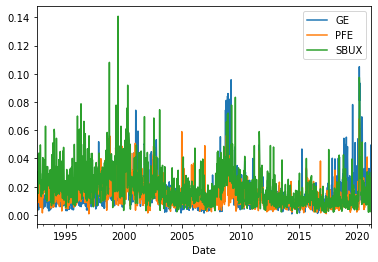

In [23]:
stocks.resample("7D").std().plot()

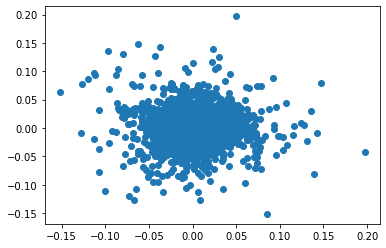

In [24]:
plt.scatter(stocks["GE"].shift(1).dropna(), stocks["GE"].iloc[1:])

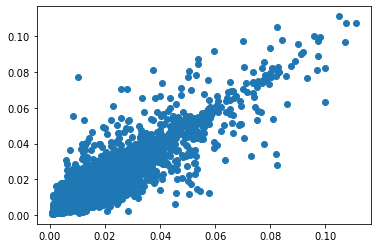

In [25]:
plt.scatter(stocks["GE"].rolling("7d").std().shift(1).dropna(), stocks["GE"].rolling("7d").std().dropna().iloc[1:])

In [47]:
X = stocks["GE"].rolling("7d").std().shift(1).dropna()
Y = stocks["GE"].rolling("7d").std().dropna().iloc[1:]
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.3, train_size = 0.7)

In [114]:
xgb_instance = xgb.XGBRegressor(objective = 'reg:linear', n_estimators = 10, learning_rate = 0.08, gamma=0, subsample=0.75, colsample_bytree=1)

In [107]:
train_data = pd.DataFrame(data = np.array(train_X), columns = ["X"])


,X,Y
0,0.014497,0.014960
1,0.014445,0.013621
2,0.004505,0.004669
3,0.008926,0.011162
4,0.015725,0.014530
...,...,...
5060,0.006401,0.012905
5061,0.006286,0.008615
5062,0.015074,0.014770
5063,0.029207,0.028346


In [115]:
xgb_instance.fit(train_X, train_Y)

[01:58:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBoostError: [01:58:01] src/objective/regression_obj.cu:65: Check failed: preds.Size() == info.labels_.Size() (1 vs. 5065) : labels are not correctly providedpreds.size=1, label.size=5065